In [95]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from PIL import Image
import torch
import math
import os

In [41]:
data = imageio.get_reader("D:/Python/Projects/GANs/Porter Robinson & Madeon - Shelter (Official Video) (Short Film with A-1 Pictures & Crunchyroll).mp4", 'ffmpeg')

In [42]:
#skip = 1 # Since the video has pratically 24 FPS, this might not be worth.
limit = 1000

In [7]:
count = 0.0

for time_step, _ in enumerate(data):

    count += 1

In [8]:
print(count) # 8784 frames ---> +- 24,4 FPS. Animation ends at +- 8,052

8784.0


In [44]:
frames = []

for time_step, frame in enumerate(data):

    #if time_step % skip != 0:

    image = Image.fromarray(frame)

    if image.mode != "RGB":
        image = image.convert("RGB")

    image = image.resize((64, 64)) # Generating images tend to have maximum efficiency at around 32x32~64x64 pixels. Beyond that ---> ProGROW / SRGAN

    frame = np.array(image)
    #frame = frame/127.5 - 1.0 # [-1, 1] ----> Using [0, 255] to avoid vanishing gradients (LSTMs)

    image.close()
    
    frames.append(frame)

    if time_step == limit:
        break

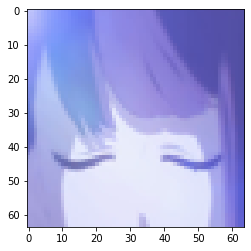

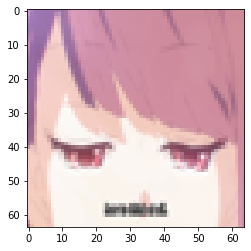

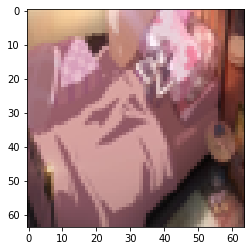

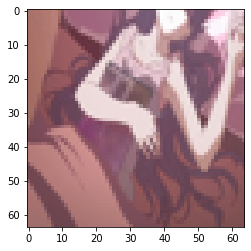

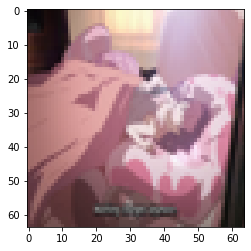

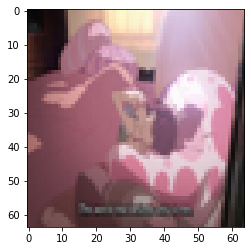

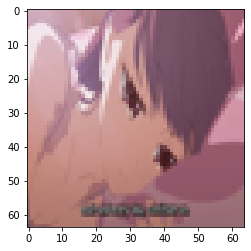

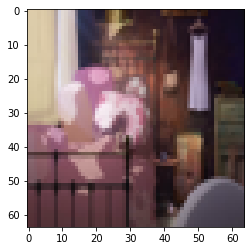

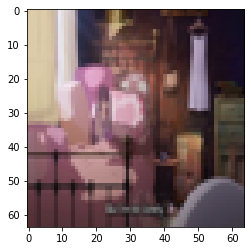

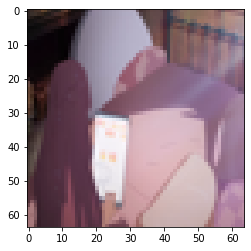

In [46]:
for i in range(500, 1000, 50):
    plt.imshow(frames[i])
    plt.show()

In [45]:
frame_rate = 24

fps = []

for i in range(frame_rate, len(frames)):

    time_step = frames[i-frame_rate:i]
    
    fps.append(time_step)


fps = np.array(fps)
fps = np.stack(fps, 0)

print(fps.shape)

(977, 24, 64, 64, 3)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Dataset: (Samples, Timesteps(24?), Channels, Height, Width)
# Generate a single image for timestep and concatenate everything in the end?
# Generate images and passing them into LSTMs?
# Attention layers?
# (Batch, Sequence_length, )

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):

        data = torch.from_numpy(data)
        self.data = data.view(data.size(0), data.size(1), data.size(4), data.size(2), data.size(3))

    def __getitem__(self, idx):

        fps = self.data[idx]

        return fps

    def __len__(self):

        return len(self.data)

In [8]:
dataset = Dataset(fps)

In [20]:
print(dataset.data.size())

torch.Size([977, 24, 3, 64, 64])


In [ ]:
# (Batch, time_steps, channels, height, width) = (Batch, 24, 3, 200, 200)
# DeepMind's DVD-GAN pass the random_noise into a Conv2D GRU which will generate the 1st frame. Its output also goes to another ConvGRU which will generate the next...
# It uses 2 discriminators, one to classify each frame, another to classify an entire sequence.
# https://github.com/happyjin/ConvGRU-pytorch/blob/master/convGRU.py


# Possibility 1) Generator: gets random_noise, generates an image per time_step ---> concatenates it all in the end.
# Discriminator1 classifies each image(Conv2D). Discriminator2 classifies entire sequence(LSTMs? Conv2Ds?)

In [52]:
def transconv2out(input, kernel, stride, padding):
    x = (input-1)*stride
    y = 2*padding
    z = 1*(kernel-1)

    output = x - y + z + 1
    return output

In [130]:
print(transconv2out(36, 5, 1, 0))

40


In [21]:
def conv2out(input, kernel, stride, padding):
    x = 2*padding
    y = 1*(kernel-1)
    z = (input + x - y - 1)/stride

    output = z + 1
    return output

In [25]:
print(conv2out(60, 2, 2, 0))

30.0


In [9]:
class Generator(torch.nn.Module):

    def __init__(self, frame_rate):

        super(Generator, self).__init__()

        self.transconv1 = torch.nn.ConvTranspose2d(100, 100, 4, 1, 0, bias=False) # 4x4
        self.batchnorm1 = torch.nn.BatchNorm2d(100)
        self.transconv2 = torch.nn.ConvTranspose2d(100, 90, 5, 1, 0, bias=False) # 8x8
        self.batchnorm2 = torch.nn.BatchNorm2d(90)
        self.transconv3 = torch.nn.ConvTranspose2d(90, 80, 5, 1, 0, bias=False) # 12x12
        self.batchnorm3 = torch.nn.BatchNorm2d(80)
        self.transconv4 = torch.nn.ConvTranspose2d(80, 70, 5, 1, 0, bias=False) # 16x16
        self.batchnorm4 = torch.nn.BatchNorm2d(70)
        self.transconv5 = torch.nn.ConvTranspose2d(70, 60, 5, 1, 0, bias=False) # 20x20
        self.batchnorm5 = torch.nn.BatchNorm2d(60)
        self.transconv6 = torch.nn.ConvTranspose2d(60, 50, 5, 1, 0, bias=False) # 24x24
        self.batchnorm6 = torch.nn.BatchNorm2d(50)
        self.transconv7 = torch.nn.ConvTranspose2d(50, 40, 5, 1, 0, bias=False) # 28x28
        self.batchnorm7 = torch.nn.BatchNorm2d(40)
        self.transconv8 = torch.nn.ConvTranspose2d(40, 30, 5, 1, 0, bias=False) # 32x32
        self.batchnorm8 = torch.nn.BatchNorm2d(30)
        self.transconv9 = torch.nn.ConvTranspose2d(30, 20, 9, 1, 0, bias=False) # 40x40
        self.batchnorm9 = torch.nn.BatchNorm2d(20)
        self.transconv10 = torch.nn.ConvTranspose2d(20, 10, 9, 1, 0, bias=False) # 48x48
        self.batchnorm10 = torch.nn.BatchNorm2d(10)
        self.transconv11 = torch.nn.ConvTranspose2d(10, 6, 9, 1, 0, bias=False) # 56x56
        self.batchnorm11 = torch.nn.BatchNorm2d(6)
        self.transconv12 = torch.nn.ConvTranspose2d(6, 3, 9, 1, 0, bias=False) # 64x64

        self.Relu = torch.nn.ReLU()

        self.conv1 = torch.nn.Conv2d(3, 40, 5, 1, 0, bias=False) # 64 --> 60
        self.pool1 = torch.nn.AvgPool2d(5, 2, 0) # 60 --> 28
        self.conv2 = torch.nn.Conv2d(40, 80, 6, 2, 0, bias=False) # 28 --> 12
        self.pool2 = torch.nn.AvgPool2d(7, 2, 0) # 12 --> 3
        self.conv3 = torch.nn.Conv2d(80, 100, 3, 1, 0, bias=False) # 3 --> 1
    
    def forward(self, input, target):

        batch_size = target.size(0)
        frame_rate = target.size(1) # Target size (Batch, frame_rate, channels, height, width)

        generated_frames = []

        for frame in range(frame_rate):

            frame_target = target[batch_size//2:, frame] # (Batch, channels, height, width)

            if frame > 0:
                # Since we concatenate the output to a target to condition it, why not concatenate the input to the previous frame?
                previous_frame = generated_frames[-1]
                previous_frame = previous_frame[:, 0] # (Batch, channels, height, width)

                previous_frame = self.conv1(previous_frame)
                previous_frame = self.Relu(previous_frame)
                previous_frame = self.pool1(previous_frame)

                previous_frame = self.conv2(previous_frame)
                previous_frame = self.Relu(previous_frame)
                previous_frame = self.pool2(previous_frame)

                previous_frame = self.conv3(previous_frame)
                previous_frame = self.Relu(previous_frame) # (Batch, 100, 1, 1) --> same as random_noise

                input = previous_frame

            x = self.transconv1(input)
            x = self.Relu(x)

            x = self.batchnorm1(x)

            x = self.transconv2(x)
            x = self.Relu(x)

            x = self.batchnorm2(x)

            x = self.transconv3(x)
            x = self.Relu(x)

            x = self.batchnorm3(x)

            x = self.transconv4(x)
            x = self.Relu(x)

            x = self.batchnorm4(x)

            x = self.transconv5(x)
            x = self.Relu(x)

            x = self.batchnorm5(x)

            x = self.transconv6(x)
            x = self.Relu(x)

            x = self.batchnorm6(x)

            x = self.transconv7(x)
            x = self.Relu(x)

            x = self.batchnorm7(x)

            x = self.transconv8(x)
            x = self.Relu(x)

            x = self.batchnorm8(x)

            x = self.transconv9(x)
            x = self.Relu(x)

            x = self.batchnorm9(x)

            x = self.transconv10(x)
            x = self.Relu(x)

            x = self.batchnorm10(x)

            x = self.transconv11(x)
            x = self.Relu(x)

            x = self.batchnorm11(x)

            x = self.transconv12(x)

            x = x[:batch_size//2]

            output_frame = torch.cat((x, frame_target), 0) # concatenating target to gen's output to condition the output (WaveGlow)

            output_frame = output_frame.unsqueeze(1) # time_step = 1

            generated_frames.append(output_frame)

        generated_frames = torch.cat(generated_frames, 1) # (Batch, frame_rate, channels, height, width)

        return generated_frames
        

In [10]:
class Discriminator1(torch.nn.Module):

    def __init__(self):

        super(Discriminator1, self).__init__()

        self.conv1 = torch.nn.Conv2d(3, 10, 9, 1, 0, bias=False) # 56x56
        self.batchnorm1 = torch.nn.BatchNorm2d(10)
        self.conv2 = torch.nn.Conv2d(10, 20, 9, 1, 0, bias=False) # 48x48
        self.batchnorm2 = torch.nn.BatchNorm2d(20)
        self.conv3 = torch.nn.Conv2d(20, 40, 9, 1, 0, bias=False) # 40x40
        self.batchnorm3 = torch.nn.BatchNorm2d(40)
        self.conv4 = torch.nn.Conv2d(40, 80, 9, 1, 0, bias=False) # 32x32
        self.batchnorm4 = torch.nn.BatchNorm2d(80)
        self.conv5 = torch.nn.Conv2d(80, 120, 9, 1, 0, bias=False) # 24x24
        self.batchnorm5 = torch.nn.BatchNorm2d(120)
        self.conv6 = torch.nn.Conv2d(120, 240, 9, 1, 0, bias=False) # 16x16
        self.batchnorm6 = torch.nn.BatchNorm2d(240)
        self.conv7 = torch.nn.Conv2d(240, 480, 9, 1, 0, bias=False) # 8x8
        self.batchnorm7 = torch.nn.BatchNorm2d(480)
        self.conv8 = torch.nn.Conv2d(480, 1, 8, 1, 0, bias=False) # 1x1

        self.Relu = torch.nn.ReLU()

    def forward(self, input):

        output = [] # List of label prediction
        features_list = []

        for time_step in range(input.size(1)):

            frame = input[:, time_step]

            x = self.conv1(frame)
            x = self.batchnorm1(x)
            x = self.Relu(x)

            x = self.conv2(x)
            x = self.batchnorm2(x)
            x = self.Relu(x)

            x = self.conv3(x)
            x = self.batchnorm3(x)
            x = self.Relu(x)

            features = self.conv4(x) # Maximum amount of features ----> Can be used for content loss
            features_list.append(features)

            x = self.batchnorm4(features)
            x = self.Relu(x)

            x = self.conv5(x)
            x = self.batchnorm5(x)
            x = self.Relu(x)

            x = self.conv6(x)
            x = self.batchnorm6(x)
            x = self.Relu(x)

            x = self.conv7(x)
            x = self.batchnorm7(x)
            x = self.Relu(x)

            x = self.conv8(x)

            x = x.view(x.size(0), -1) # (Batch, 1)
            
            output.append(x)

        output = torch.cat(output, 1) # (Batch, Frames) ---> Each frame = 1 label

        features_list = torch.cat(features_list, 0)
        features_list = features_list.view(input.size(0), input.size(1), 80, 32, 32) # (Batch, Frames, 80, 32, 32)

        return output, features_list

In [33]:
model = Discriminator1().to(device)

from torchsummary import summary

summary(model, (1, 3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 56, 56]           2,430
       BatchNorm2d-2           [-1, 10, 56, 56]              20
              ReLU-3           [-1, 10, 56, 56]               0
            Conv2d-4           [-1, 20, 48, 48]          16,200
       BatchNorm2d-5           [-1, 20, 48, 48]              40
              ReLU-6           [-1, 20, 48, 48]               0
            Conv2d-7           [-1, 40, 40, 40]          64,800
       BatchNorm2d-8           [-1, 40, 40, 40]              80
              ReLU-9           [-1, 40, 40, 40]               0
           Conv2d-10           [-1, 80, 32, 32]         259,200
      BatchNorm2d-11           [-1, 80, 32, 32]             160
             ReLU-12           [-1, 80, 32, 32]               0
           Conv2d-13          [-1, 120, 24, 24]         777,600
      BatchNorm2d-14          [-1, 120,

In [11]:
class Discriminator2(torch.nn.Module):

    def __init__(self):

        super(Discriminator2, self).__init__()

        # LSTM only accepts 3D inputs...and I'm not really interested in making a ConvGRU
        # (Batch, Frame_rate, 3, 64, 64) -----> Conv3D + Conv2D

        self.conv3D = torch.nn.Conv3d(24, 24, 3, bias=False) # 62x62
        self.conv2D = torch.nn.Conv2d(24, 24, 4, 2, 0, bias=False) # 30x30


        self.lstm = torch.nn.LSTM(900, 10, 50, batch_first=True, dropout=0, bidirectional=True, bias=False)

        self.neuron = torch.nn.Linear(10*2, 1, bias=False)

        self.batchnorm2D = torch.nn.BatchNorm2d(24)

        self.Relu = torch.nn.ReLU()


    def forward(self, input):

        x = self.conv3D(input) # (Batch, 24, 1, 62, 62)
        x = self.Relu(x)

        x = x.squeeze(2) # (Batch, 24, 62, 62)
        
        x = self.conv2D(x) # (Batch, 24, 30, 30)
        x = self.Relu(x)

        x = self.batchnorm2D(x)

        x = x.view(x.size(0), x.size(1), -1) # (Batch, 24, 900)

        x, hidden = self.lstm(x) # (Batch, frame_rate, 900*2[bidirectional])

        x = x[:, -1] # Returns only the last output in the output sequence ---> (Batch, 900*2)

        output = self.neuron(x)

        output = output.view(-1)

        return output

In [12]:
costsG = []
costsD1 = []
costsD2 = []
GLR = []
DLR1 = []
DLR2 = []
Ggrads = []
D1grads = []
D2grads = []

In [13]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

In [14]:
Gen = Generator(24).to(device)
Goptim = torch.optim.AdamW(Gen.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0)
Gscheduler = torch.optim.lr_scheduler.StepLR(Goptim, 1, gamma=0.1)

D1 = Discriminator1().to(device)
D1optim = torch.optim.AdamW(D1.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0)
D1scheduler = torch.optim.lr_scheduler.StepLR(D1optim, 1, gamma=0.1)

D2 = Discriminator2().to(device)
D2optim = torch.optim.AdamW(D2.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0)
D2scheduler = torch.optim.lr_scheduler.StepLR(D2optim, 1, gamma=0.1)

In [15]:
real_label = 0.9
fake_label = 0.

In [16]:
adversarial_loss = torch.nn.BCEWithLogitsLoss()
content_loss = torch.nn.MSELoss()
beta = 1e-3
grad_clip = None

In [57]:
for epoch in range(2):
    
    for i, fps in enumerate(dataloader):

        fps = fps.to(device).float()

        D1.zero_grad()
        D2.zero_grad()
        Gen.zero_grad()

        labels_frames = torch.full((fps.size(0), fps.size(1)), real_label, device=device)

        labels_sequence = torch.full((fps.size(0),), real_label, device=device)

        D1out, featuresReal = D1(fps)

        errorD1_real = adversarial_loss(D1out, labels_frames)

        errorD1_real.backward()

        D2out = D2(fps)

        errorD2_real = adversarial_loss(D2out, labels_sequence)

        errorD2_real.backward()

        noise = torch.normal(0, 1000, size=(fps.size(0), 100, 1, 1), device=device)

        fake_fps = Gen(noise, fps)

        labels_frames = labels_frames.fill_(fake_label)

        labels_sequence = labels_sequence.fill_(fake_label)

        D1out, _ = D1(fake_fps.detach())

        errorD1_fake = adversarial_loss(D1out, labels_frames)

        errorD1_fake.backward()

        D2out = D2(fake_fps.detach())

        errorD2_fake = adversarial_loss(D2out, labels_sequence)

        errorD2_fake.backward()

        errorD1 = errorD1_real.item() + errorD1_fake.item()
        
        costsD1.append(errorD1)

        errorD2 = errorD2_real.item() + errorD2_fake.item()
        
        costsD2.append(errorD2)

        for p in D1.parameters():
            g = p.clone()

            D1grads.append(torch.mean(g).item())

            if grad_clip is not None:
                p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))

        for p in D2.parameters():
            g = p.clone()

            D2grads.append(torch.mean(g).item())

            if grad_clip is not None:
                p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))

        D1optim.step()
        D2optim.step()

        del errorD1_real, errorD1_fake, errorD2_real, errorD2_fake

        Gen.zero_grad()

        fake_fps = Gen(noise, fps)

        D1labels, featuresFake = D1(fake_fps)
        D2labels = D2(fake_fps)

        labels_frames = labels_frames.fill_(real_label)

        labels_sequence = labels_sequence.fill_(real_label)

        # How to calculate the loss for each discriminator? Should they have equal weight?

        frame_loss = adversarial_loss(D1labels, labels_frames)
        fps_loss = adversarial_loss(D2labels, labels_sequence)
        content_cost = content_loss(featuresFake, featuresReal.detach()) # The featuresReal is our "label" for content, so it must be detached

        perceptual_loss = (content_cost * beta) + (frame_loss + fps_loss) # Applying beta to content cost since diversity is good, but the frames must make sense.

        perceptual_loss.backward()

        costsG.append(perceptual_loss.item())


        for p in Gen.parameters():
            g = p.clone()

            Ggrads.append(torch.mean(g).item())

            if grad_clip is not None:
                p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))

        Goptim.step()

KeyboardInterrupt: 

In [104]:
def train_VideoGAN(
    dataset=None,
    batch_size=16,
    epochs=1000,
    checkpoint=100,
    lr=1,
    beta=1e-3,
    frame_rate=24,
    grad_clip=None,
    save_path=None,
):

    Gen = Generator(frame_rate).to(device)
    Goptim = torch.optim.AdamW(Gen.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0)
    Gscheduler = torch.optim.lr_scheduler.StepLR(Goptim, 1, gamma=0.1)

    D1 = Discriminator1().to(device)
    D1optim = torch.optim.AdamW(D1.parameters(), lr=lr*0.1, betas=(0.9, 0.999), weight_decay=0)
    D1scheduler = torch.optim.lr_scheduler.StepLR(D1optim, 1, gamma=0.1)

    D2 = Discriminator2().to(device)
    D2optim = torch.optim.AdamW(D2.parameters(), lr=lr*0.1, betas=(0.9, 0.999), weight_decay=0)
    D2scheduler = torch.optim.lr_scheduler.StepLR(D2optim, 1, gamma=0.1)


    if save_path is None:

        start_epoch = 0

        for name, param in Gen.named_parameters():
            if "weight" in name:
                torch.nn.init.normal_(param, 0, 0.01)
            
            if "bias" in name:
                torch.nn.init.constant_(param, 0.0)

        for name, param in D1.named_parameters():
            if "weight" in name:
                torch.nn.init.normal_(param, 0, 0.01)
            
            if "bias" in name:
                torch.nn.init.constant_(param, 0.0)
        
        for name, param in D2.named_parameters():
            if "weight" in name:
                torch.nn.init.normal_(param, 0, 0.01)
            
            if "bias" in name:
                torch.nn.init.constant_(param, 0.0)

    else:

        params = torch.load(f"{save_path}/VideoGAN_checkpoint.json")

        start_epoch = params['Epoch'] + 1
        Gen.load_state_dict(params['Generator_Params'])
        D1.load_state_dict(params['Discriminator1_Params'])
        D2.load_state_dict(params['Discriminator2_Params'])
        lr = params['Discriminator_LR']

        print(f"\nLoaded checkpoint from epoch {start_epoch}")


    adversarial_loss = torch.nn.BCEWithLogitsLoss()
    content_loss = torch.nn.MSELoss()
    beta = beta

    Gen.train()
    D1.train()
    D2.train()

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        
        for i, fps in enumerate(dataloader):

            fps = fps.to(device).float()

            D1.zero_grad()
            D2.zero_grad()
            Gen.zero_grad()

            labels_frames = torch.full((fps.size(0), fps.size(1)), real_label, device=device)

            labels_sequence = torch.full((fps.size(0),), real_label, device=device)

            D1out, featuresReal = D1(fps)

            errorD1_real = adversarial_loss(D1out, labels_frames)

            errorD1_real.backward()

            D2out = D2(fps)

            errorD2_real = adversarial_loss(D2out, labels_sequence)

            errorD2_real.backward()

            noise = torch.normal(0, 1000, size=(fps.size(0), 100, 1, 1), device=device)

            fake_fps = Gen(noise, fps)

            labels_frames = labels_frames.fill_(fake_label)

            labels_sequence = labels_sequence.fill_(fake_label)

            D1out, _ = D1(fake_fps.detach())

            errorD1_fake = adversarial_loss(D1out, labels_frames)

            errorD1_fake.backward()

            D2out = D2(fake_fps.detach())

            errorD2_fake = adversarial_loss(D2out, labels_sequence)

            errorD2_fake.backward()

            errorD1 = errorD1_real.item() + errorD1_fake.item()
            
            costsD1.append(errorD1)

            errorD2 = errorD2_real.item() + errorD2_fake.item()
            
            costsD2.append(errorD2)

            for p in D1.parameters():
                g = p.clone()

                D1grads.append(torch.mean(g).item())

                if grad_clip is not None:
                    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))

            for p in D2.parameters():
                g = p.clone()

                D2grads.append(torch.mean(g).item())

                if grad_clip is not None:
                    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))

            D1optim.step()
            D2optim.step()

            del errorD1_real, errorD1_fake, errorD2_real, errorD2_fake

            Gen.zero_grad()

            fake_fps = Gen(noise, fps)

            D1labels, featuresFake = D1(fake_fps)
            D2labels = D2(fake_fps)

            labels_frames = labels_frames.fill_(real_label)

            labels_sequence = labels_sequence.fill_(real_label)

            # How to calculate the loss for each discriminator? Should they all have equal weight?

            frame_loss = adversarial_loss(D1labels, labels_frames)
            fps_loss = adversarial_loss(D2labels, labels_sequence)
            content_cost = content_loss(featuresFake, featuresReal.detach()) # The featuresReal is our "label" for content, so it must be detached

            perceptual_loss = (content_cost * beta) + (frame_loss + fps_loss) # Applying beta to content cost since diversity is good, but the frames must make sense.

            perceptual_loss.backward()

            costsG.append(perceptual_loss.item())


            for p in Gen.parameters():
                g = p.clone()

                Ggrads.append(torch.mean(g).item())

                if grad_clip is not None:
                    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))

            Goptim.step()

            best_D1_loss = float('inf')
            best_D2_loss = float('inf')
            best_gen_loss = float('inf')

            if errorD1 < best_D1_loss:

                best_D1_loss = errorD1
                best_D1_params = D1.state_dict()

            if errorD2 < best_D2_loss:

                best_D2_loss = errorD2
                best_D2_params = D2.state_dict()

            if perceptual_loss.item() < best_gen_loss:

                best_gen_loss = perceptual_loss.item()
                best_gen_params = Gen.state_dict()


            if i % checkpoint == 0:

                print(f"{epoch}/{epochs}")
                print(f"Best D1 Loss: {best_D1_loss}\tCurrent LR: {D1scheduler.get_last_lr()[0]}\tGrads Average: {D1grads[-1]}")
                print(f"Best D2 Loss: {best_D2_loss}\tCurrent LR: {D2scheduler.get_last_lr()[0]}\tGrads Average: {D2grads[-1]}")
                print(f"Best Generator Loss: {best_gen_loss}\tCurrent LR: {Gscheduler.get_last_lr()[0]}\tGrads Average: {Ggrads[-1]}")

                if save_path is None:
                    try:
                        os.mkdir("Video_GAN")
                        save_path = "Video_GAN"
                    except:
                        save_path = "Video_GAN"
                        
                torch.save({
                    'Epoch': epoch,
                    'Generator_Params': best_gen_params,
                    'Discriminator1_Params': best_D1_params,
                    'Discriminator2_Params': best_D2_params,
                    'Discriminator_LR': D1scheduler.get_last_lr()[0]
                }, f"{save_path}/VideoGAN_checkpoint.json")

                print("Models saved!")

                with torch.no_grad():

                    sample = Gen(noise, fps)

                    image_samples = sample.detach().view(sample.size(0), sample.size(1), sample.size(3), sample.size(4), sample.size(2)).cpu().long().numpy()

                    fig, ax = plt.subplots(6,4)
                    for x in range(ax.shape[0]):
                        for y in range(ax.shape[1]):
                            ax[x,y].axis("off")

                    ax[0,0].imshow(image_samples[0, 0])
                    ax[0,1].imshow(image_samples[0, 1])
                    ax[0,2].imshow(image_samples[0, 2])
                    ax[0,3].imshow(image_samples[0, 3])
                    ax[1,0].imshow(image_samples[0, 4])
                    ax[1,1].imshow(image_samples[0, 5])
                    ax[1,2].imshow(image_samples[0, 6])
                    ax[1,3].imshow(image_samples[0, 7])
                    ax[2,0].imshow(image_samples[0, 8])
                    ax[2,1].imshow(image_samples[0, 9])
                    ax[2,2].imshow(image_samples[0, 10])
                    ax[2,3].imshow(image_samples[0, 11])
                    ax[3,0].imshow(image_samples[0, 12])
                    ax[3,1].imshow(image_samples[0, 13])
                    ax[3,2].imshow(image_samples[0, 14])
                    ax[3,3].imshow(image_samples[0, 15])
                    ax[4,0].imshow(image_samples[0, 16])
                    ax[4,1].imshow(image_samples[0, 17])
                    ax[4,2].imshow(image_samples[0, 18])
                    ax[4,3].imshow(image_samples[0, 19])
                    ax[5,0].imshow(image_samples[0, 20])
                    ax[5,1].imshow(image_samples[0, 21])
                    ax[5,2].imshow(image_samples[0, 22])
                    ax[5,3].imshow(image_samples[0, 23])
                
                    plt.show()

                    samples = [Image.fromarray(image_samples[0, i].astype(np.uint8)) for i in range(image_samples.shape[1])]

                    samples[0].save(f"{save_path}/sequence_sample_{epoch}.gif", save_all=True, append_images=samples[1:])

                    del samples, sample, image_samples



            del errorD1, errorD2, perceptual_loss, noise


        Gscheduler.step()
        D1scheduler.step()
        D2scheduler.step()

In [ ]:
train_VideoGAN(
    dataset=dataset,
    batch_size=1,
    epochs=10,
    checkpoint=100,
    lr=1,
    beta=1e-3,
    frame_rate=24,
    grad_clip=None,
    save_path=None    
)

In [58]:
print(fake_fps.size())

torch.Size([2, 24, 3, 64, 64])


In [75]:
image_samples = fake_fps.detach().view(fake_fps.size(0), fake_fps.size(1), fake_fps.size(3), fake_fps.size(4), fake_fps.size(2)).cpu().long().numpy()

# DON'T USE .permute()!!!! IT MESSES THE IMAGE COMPLETELY

In [80]:
print(image_samples[0, 23])

[[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [-2 -2 -1]
  [-1 -1  0]
  [ 0  0  0]]

 [[ 0  0 -1]
  [-1 -2 -2]
  [-3 -3 -3]
  ...
  [-5 -5 -4]
  [-3 -3 -2]
  [-1  0  0]]

 [[ 0 -1 -2]
  [-3 -4 -4]
  [-4 -5 -6]
  ...
  [-8 -9 -7]
  [-6 -5 -4]
  [-3 -2 -1]]

 ...

 [[ 0  1  2]
  [ 2  2  3]
  [ 2  1  3]
  ...
  [ 4  3  3]
  [ 2  2  1]
  [ 0  0  0]]

 [[ 0  0  1]
  [ 1  1  2]
  [ 2  1  2]
  ...
  [ 1  1  1]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]


In [79]:
print(fps[0, 23].long())

tensor([[[218, 189, 152,  ..., 205, 165, 225],
         [195, 156, 213,  ..., 219, 234, 209],
         [219, 232, 179,  ...,  55,  35,  37],
         ...,
         [ 93, 113, 157,  ..., 125, 195, 150],
         [165, 199, 159,  ..., 105,  52,  43],
         [159, 110, 117,  ...,  96, 114, 152]],

        [[ 92, 110, 152,  ..., 143, 223, 192],
         [197, 182, 142,  ...,  99,  50,  42],
         [159, 110, 118,  ...,  95, 111, 152],
         ...,
         [ 81, 120,  73,  ...,  95,  65,  54],
         [114,  72,  84,  ..., 159, 158, 211],
         [159, 158, 211,  ..., 110, 129,  77]],

        [[ 85, 118,  71,  ...,  85,  57,  48],
         [113,  72,  83,  ..., 158, 157, 210],
         [158, 157, 209,  ..., 120, 127,  77],
         ...,
         [ 48,  40,  46,  ...,  74,  82, 138],
         [ 95, 100, 182,  ...,  53,  77,  68],
         [ 57,  77,  67,  ..., 105,  75,  73]]], device='cuda:0')


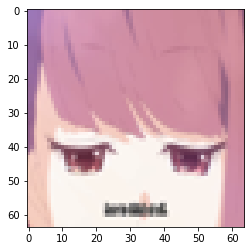

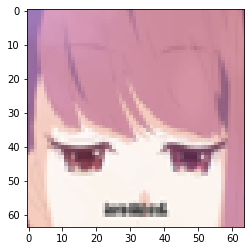

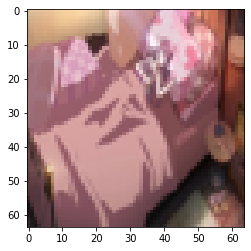

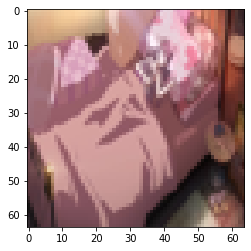

In [74]:
original = fps.view(fps.size(0), fps.size(1), fps.size(3), fps.size(4), fps.size(2)).cpu().long().numpy()
#fps.permute(0, 1, 3, 4, 2).cpu().long().numpy()

for i in range(0, original.shape[1], 6):
    plt.imshow(original[0, i])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


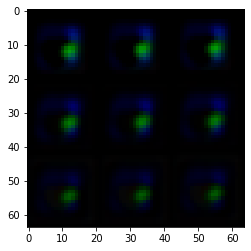

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


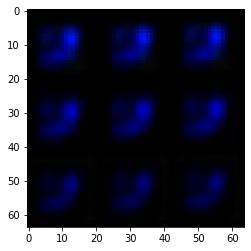

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


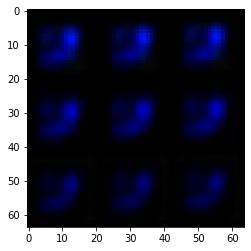

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


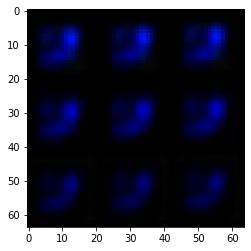

In [78]:
for i in range(0, image_samples.shape[1], 6):
    plt.imshow(image_samples[0, i])
    plt.show()